<a href="https://colab.research.google.com/github/JaeElCee/LCO/blob/main/LCO_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install reproject photutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.2/195.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.9 MB/s eta 0:00:00


In [2]:
from astropy.io import fits
import numpy as np
import photutils
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.cm import viridis
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.patches import Ellipse as plotEllipse
from photutils import detection, centroids
from photutils.aperture import EllipticalAperture, CircularAperture, aperture_photometry
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from astropy.stats import sigma_clipped_stats
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from reproject import reproject_interp
from scipy.ndimage import shift, gaussian_filter1d, binary_dilation
from scipy.spatial import cKDTree
from skimage.measure import find_contours
from skimage.draw import polygon
from IPython.display import HTML


import warnings
warnings.filterwarnings('ignore')

In [3]:
#import fits data and header
VfitLoc = "//content/drive/MyDrive/LCOdata/V/Vstack.fits"
ipfitLoc = "//content/drive/MyDrive/LCOdata/ip/ipstack.fits"
rpfitLoc = "//content/drive/MyDrive/LCOdata/rp/rpstack.fits"
Vfits_data = fits.getdata(VfitLoc)
ipfits_data = fits.getdata(ipfitLoc)
rpfits_data = fits.getdata(rpfitLoc)
V_header = fits.getheader(VfitLoc)
ip_header = fits.getheader(ipfitLoc)
rp_header = fits.getheader(rpfitLoc)

In [4]:
#align ip and rp data to V band grid
V = Vfits_data
ip, _ = reproject_interp((ipfits_data, WCS(ip_header)), V_header)
rp, _ = reproject_interp((rpfits_data, WCS(rp_header)), V_header)

In [5]:
#Crop fits data to only include local galactic area
y_min, y_max = 1470, 2681
x_min, x_max = 1468, 2793

Cropped_V = V[y_min:y_max,x_min:x_max]
Cropped_ip = ip[y_min:y_max,x_min:x_max]
Cropped_rp = rp[y_min:y_max,x_min:x_max]

In [6]:
def improved_adaptive_star_mask(data, centroid, verbose=False):
    from photutils.detection import DAOStarFinder
    from astropy.stats import sigma_clipped_stats

    # Parameters
    base_radius = 4
    max_radius = 18
    safe_radius_core = 120  # Boosted to protect inner structure
    roundness_threshold_core = 0.65
    roundness_threshold_outer = 0.45
    no_mask_core_radius = 60  # Fully preserve the very center

    # Galaxy centroid
    cx, cy = centroid

    # Measure image stats and detect sources
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * std)
    sources = daofind(data - median)

    # Exit early if no sources
    if sources is None or len(sources) == 0:
        if verbose:
            print("No sources detected.")
        return data.copy(), np.zeros_like(data, dtype=bool)

    # Prepare mask
    mask = np.zeros(data.shape, dtype=bool)

    # Extract source properties
    xsrc = sources['xcentroid']
    ysrc = sources['ycentroid']
    fluxes = sources['flux']
    roundness = np.abs(sources['roundness1'])

    # Compute distances from galaxy center
    dx = xsrc - cx
    dy = ysrc - cy
    distances = np.sqrt(dx**2 + dy**2)

    # Classification
    is_core = distances < safe_radius_core
    is_very_central = distances < no_mask_core_radius

    # Roundness-based classification
    threshold = np.where(is_core, roundness_threshold_core, roundness_threshold_outer)
    is_star = roundness < threshold

    # Valid sources for masking
    valid = is_star & ~is_very_central

    # Filter arrays
    xsrc = xsrc[valid]
    ysrc = ysrc[valid]
    fluxes = fluxes[valid]
    distances = distances[valid]

    # Normalize brightness and distance
    flux_norm = (fluxes - np.min(fluxes)) / (np.max(fluxes) - np.min(fluxes) + 1e-6)
    distance_weight = 1 - np.clip(distances / np.max(distances), 0, 1)
    radii = base_radius + (max_radius - base_radius) * flux_norm * distance_weight

    # Draw circular masks
    for x0, y0, r in zip(xsrc, ysrc, radii):
        r = int(np.clip(r, base_radius, max_radius))
        x0, y0 = int(round(x0)), int(round(y0))

        y_grid, x_grid = np.ogrid[-r:r+1, -r:r+1]
        circle_mask = x_grid**2 + y_grid**2 <= r**2

        x1, x2 = x0 - r, x0 + r + 1
        y1, y2 = y0 - r, y0 + r + 1

        # Clip to image boundaries
        x1_clip = max(x1, 0)
        y1_clip = max(y1, 0)
        x2_clip = min(x2, data.shape[1])
        y2_clip = min(y2, data.shape[0])

        # Adjust cutout for mask
        mask_slice = mask[y1_clip:y2_clip, x1_clip:x2_clip]
        cm_slice = circle_mask[y1_clip - y1 : y2_clip - y1, x1_clip - x1 : x2_clip - x1]

        mask[y1_clip:y2_clip, x1_clip:x2_clip] |= cm_slice

    masked_data = data.copy()
    masked_data[mask] = np.nan

    if verbose:
        print(f"Masked {len(radii)} sources.")

    return masked_data, mask


In [7]:
masked_fit_V, mask_V = improved_adaptive_star_mask(Cropped_V, (603,527))
masked_fit_ip, mask_ip = improved_adaptive_star_mask(Cropped_ip, (603,527))
masked_fit_rp, mask_rp = improved_adaptive_star_mask(Cropped_rp, (603,527))

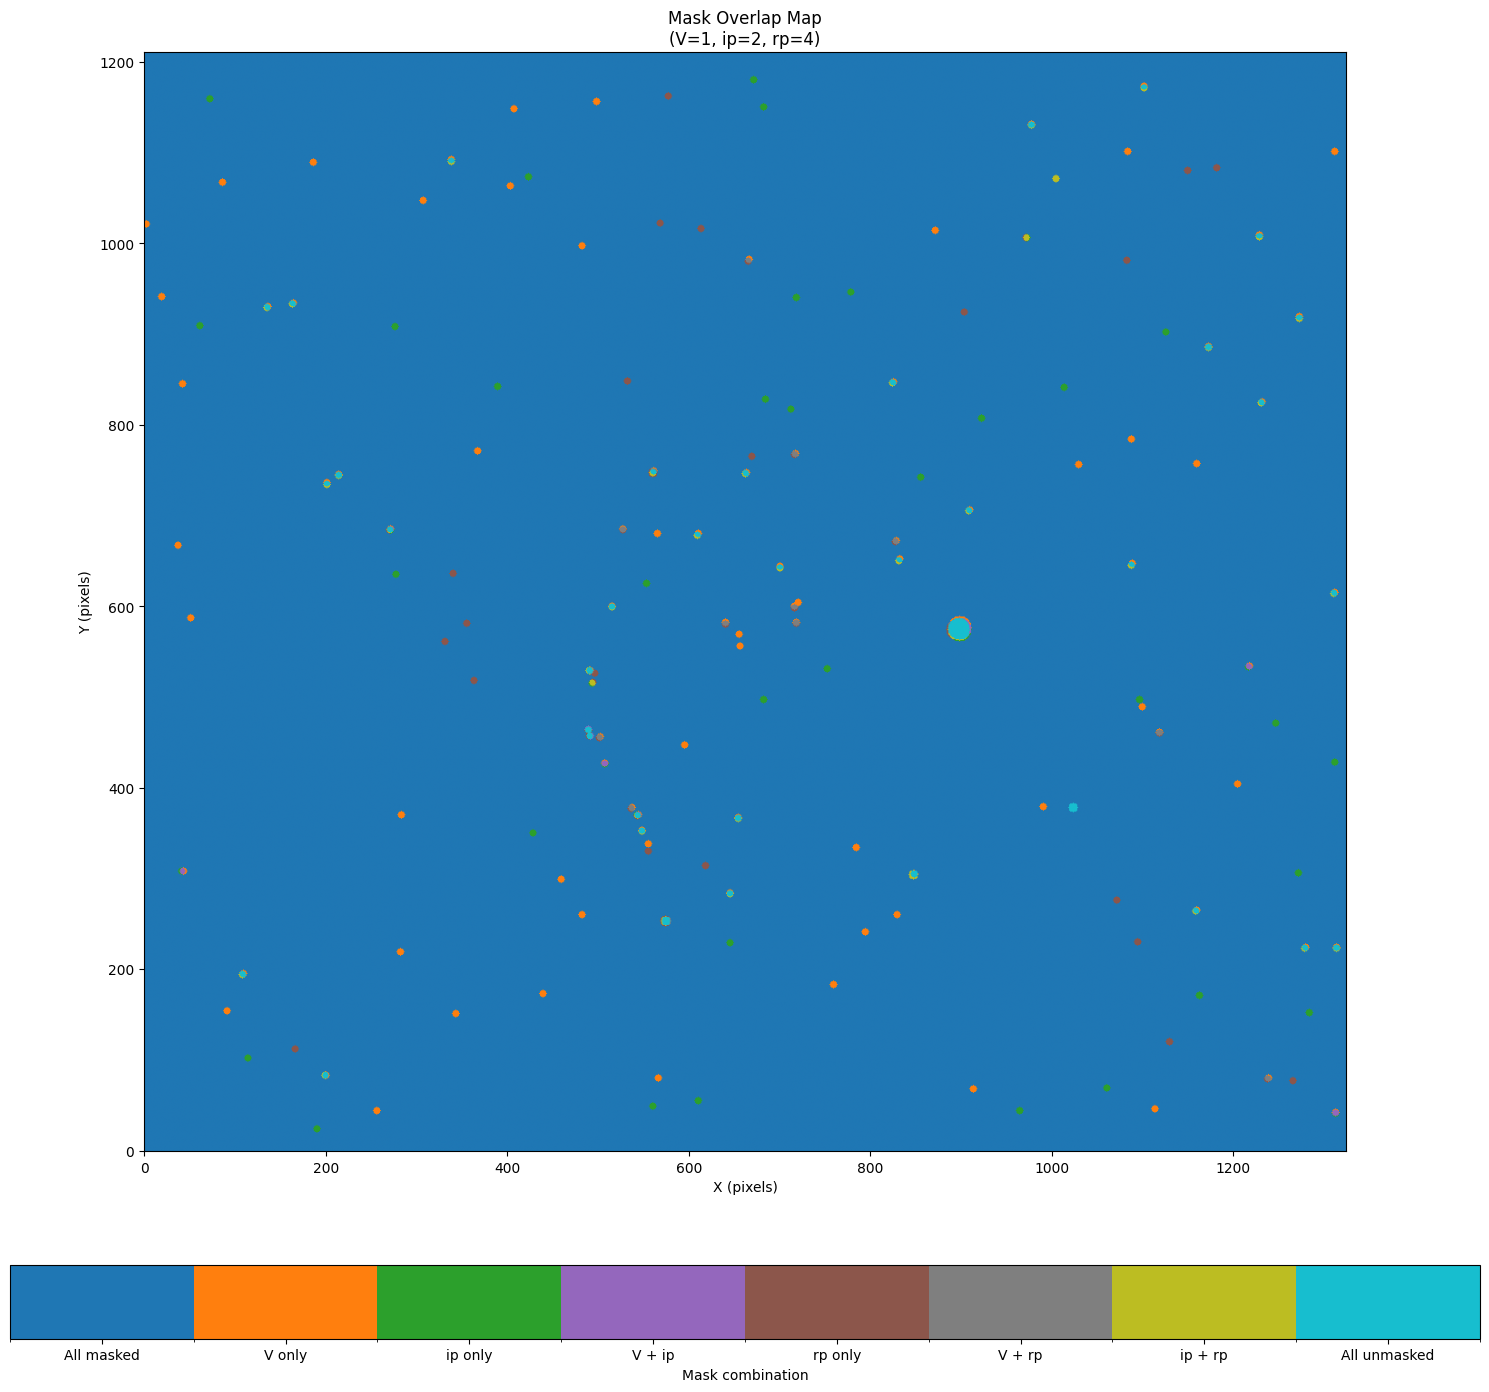

In [8]:
#Ensure masks for all bands overlap properly
print()
combined_mask = (
    mask_V.astype(int) * 1 +
    mask_ip.astype(int) * 2 +
    mask_rp.astype(int) * 4
)

labels = [
    'All masked', 'V only', 'ip only', 'V + ip',
    'rp only', 'V + rp', 'ip + rp', 'All unmasked'
]

cmap = plt.get_cmap("tab10", 8)
norm = BoundaryNorm(boundaries=np.arange(9) - 0.5, ncolors=8)

fig, ax = plt.subplots(figsize=(15, 15))
im = ax.imshow(combined_mask, origin='lower', cmap=cmap, norm=norm)
ax.set_title("Mask Overlap Map\n(V=1, ip=2, rp=4)")
ax.set_xlabel("X (pixels)")
ax.set_ylabel("Y (pixels)")

cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08)
cbar.set_ticks(np.arange(8))
cbar.set_ticklabels(labels)
cbar.set_label("Mask combination")

plt.tight_layout()
plt.show()


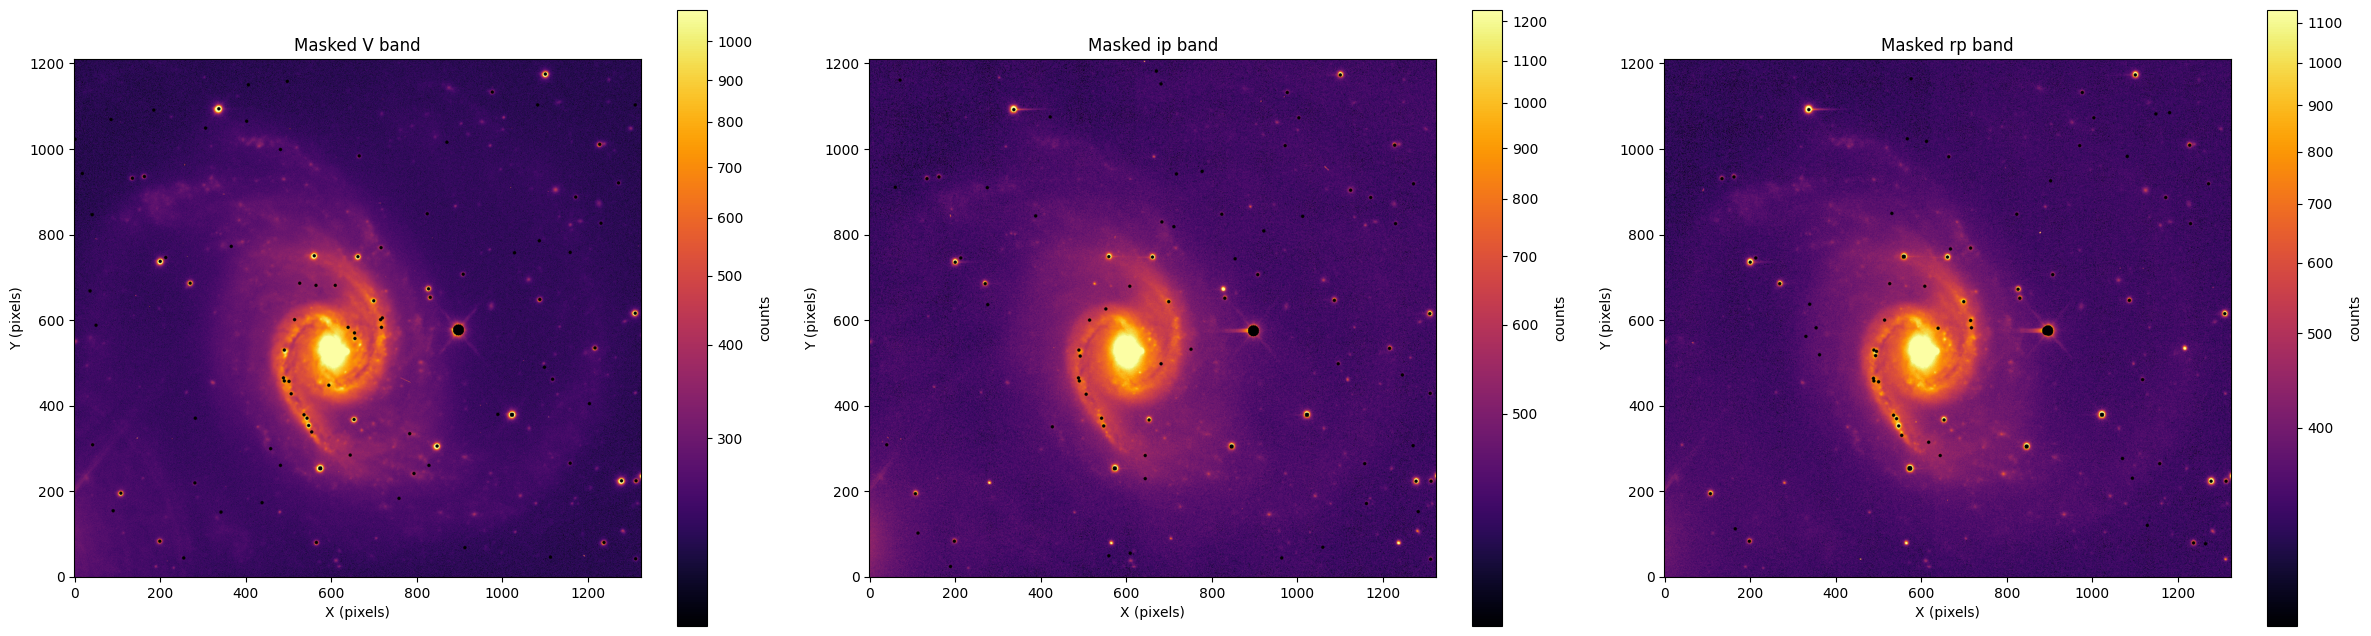

In [9]:
#visualise mask overlaid on top of fits data in each band, not adjusted by the background flux
masked_fits = [masked_fit_V, masked_fit_ip, masked_fit_rp]

fig, axes = plt.subplots(1,3, figsize = (24, 8))
for ax, data, label in zip(axes, masked_fits, ['Masked V band', 'Masked ip band', 'Masked rp band']):
  norm = simple_norm(data, "sqrt", percent = 99.5)
  cmap = plt.colormaps['inferno'].copy()
  cmap.set_bad(color = 'black')
  im = ax.imshow(data, origin="lower", cmap = cmap, norm = norm)
  plt.colorbar(im, ax = ax, shrink=0.8, label = 'counts')

  ax.set_title(label)
  ax.set_xlabel("X (pixels)")
  ax.set_ylabel("Y (pixels)")
  plt.grid(False)

plt.tight_layout()
plt.show()

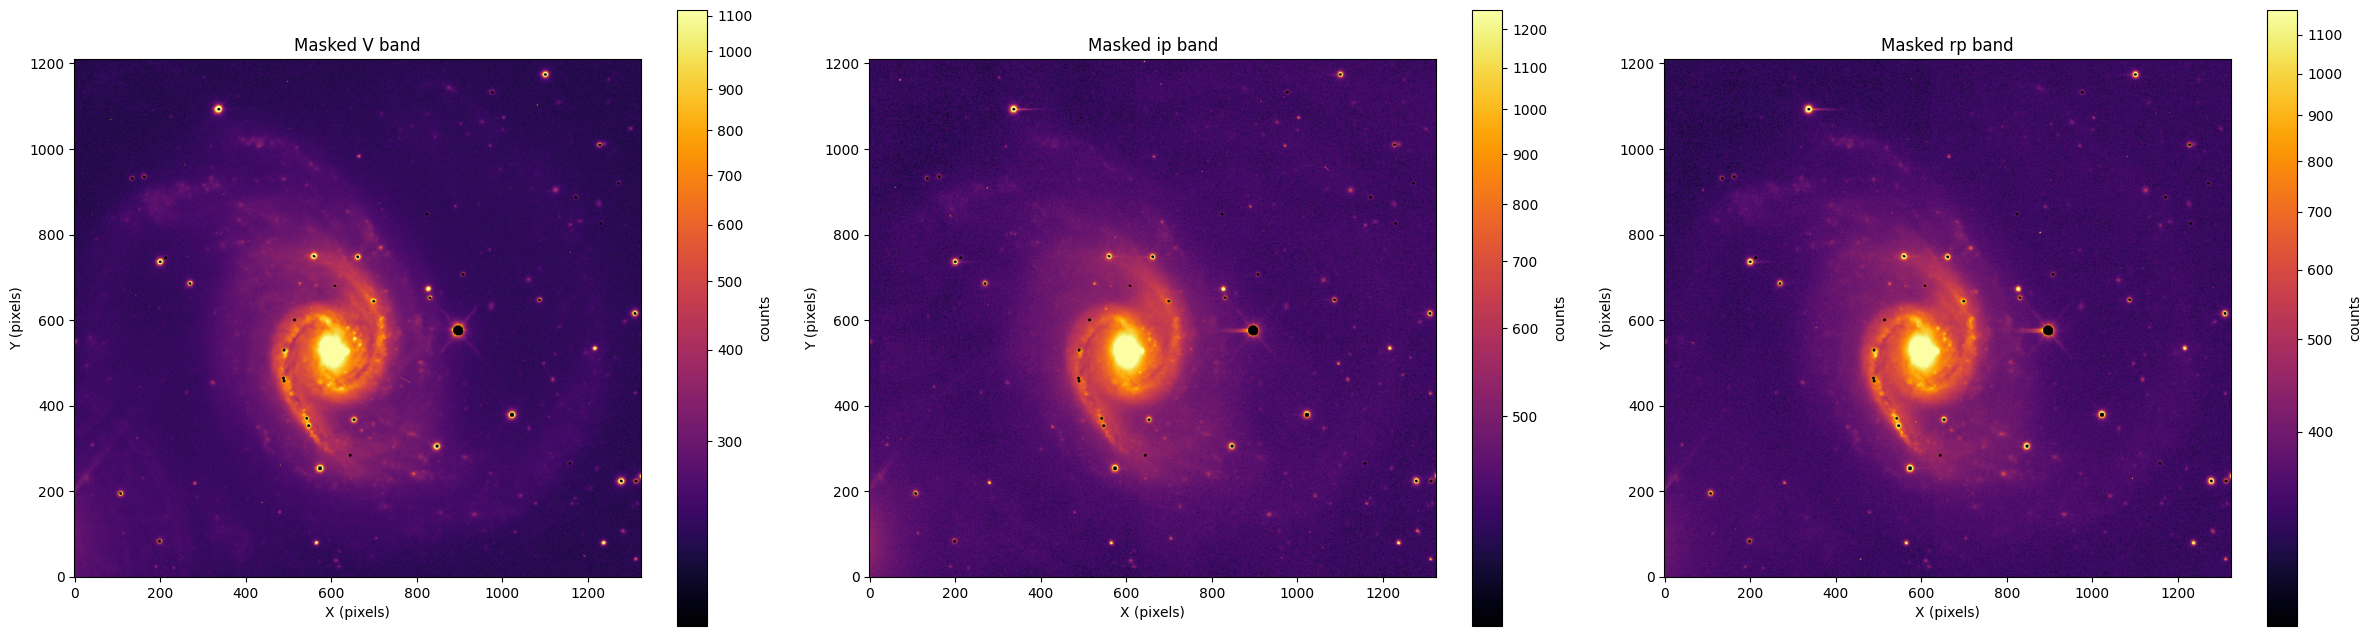

In [10]:
cropped_fits = [Cropped_V, Cropped_ip, Cropped_rp]
masks = np.array([mask_V, mask_ip, mask_rp])
sharedMask = masks[0] & masks[1] & masks[2]
shared_fits = []
for fit in cropped_fits:
  fit = np.array(fit)
  fit[sharedMask] = np.nan
  shared_fits.append(fit)
masked_fits = np.array(shared_fits)

#visualise shared mask overlaid on top of fits data in each band, not adjusted by the background flux
fig, axes = plt.subplots(1,3, figsize = (24, 8))
normV = simple_norm(shared_fits[0], "sqrt", percent = 99.5)
cmapV = plt.colormaps['inferno'].copy()
cmapV.set_bad(color = 'black')
imV = axes[0].imshow(shared_fits[0], origin="lower", cmap = cmapV, norm = normV)
plt.colorbar(imV, ax = axes[0], shrink=0.8, label = 'counts')
axes[0].set_title('Masked V band')
axes[0].set_xlabel("X (pixels)")
axes[0].set_ylabel("Y (pixels)")
plt.grid(False)
normip = simple_norm(shared_fits[1], "sqrt", percent = 99.5)
cmapip = plt.colormaps['inferno'].copy()
cmapip.set_bad(color = 'black')
imip = axes[1].imshow(shared_fits[1], origin="lower", cmap = cmapip, norm = normip)
plt.colorbar(imip, ax = axes[1], shrink=0.8, label = 'counts')
axes[1].set_title('Masked ip band')
axes[1].set_xlabel("X (pixels)")
axes[1].set_ylabel("Y (pixels)")
plt.grid(False)
normrp = simple_norm(shared_fits[2], "sqrt", percent = 99.5)
cmaprp = plt.colormaps['inferno'].copy()
cmaprp.set_bad(color = 'black')
imrp = axes[2].imshow(shared_fits[2], origin="lower", cmap = cmaprp, norm = normrp)
plt.colorbar(imrp, ax = axes[2], shrink=0.8, label = 'counts')
axes[2].set_title('Masked rp band')
axes[2].set_xlabel("X (pixels)")
axes[2].set_ylabel("Y (pixels)")
plt.grid(False)
plt.tight_layout()
plt.show()

In [11]:
#Calculate elliptical annulus parameters (Centroid coordinates, Position angle, Axis ratio)
params = []
for fits_data, label in zip(masked_fits,["V Band", "ip Band", "rp Band"]):
  mean, median, std = sigma_clipped_stats(fits_data, sigma=3.0)
  threshold = median + 3.0 * std
  mask = (fits_data > threshold)

  # Get x, y indices of significant pixels
  y, x = np.nonzero(mask)
  I = fits_data[mask]

  # Weighted centroids (optional if you already have them)
  x0 = np.average(x, weights=I)
  y0 = np.average(y, weights=I)

  # Central moments
  dx = x - x0
  dy = y - y0

  I_sum = np.sum(I)
  Mxx = np.sum(I * dx**2) / I_sum
  Myy = np.sum(I * dy**2) / I_sum
  Mxy = np.sum(I * dx * dy) / I_sum

  # Position angle (in radians): rotate so major axis aligns with x
  theta = 0.5 * np.arctan2(2 * Mxy, Mxx - Myy)
  PA_deg = np.rad2deg(theta) % 180

  # Axis ratio
  lambda1 = 0.5 * (Mxx + Myy + np.sqrt((Mxx - Myy)**2 + 4 * Mxy**2))
  lambda2 = 0.5 * (Mxx + Myy - np.sqrt((Mxx - Myy)**2 + 4 * Mxy**2))
  axis_ratio = np.sqrt(lambda2 / lambda1)
  params.append((x0, y0, theta, axis_ratio))

In [12]:
#Generate isophotes for each band, based on the elliptical annulus parameters previously generated
sma = 100
isolists = []
for data, (x0, y0, theta, axis_ratio), label in zip(masked_fits,params,["V","ip","rp"]):
  data = np.nan_to_num(data, nan = 0.0)
  geometry = EllipseGeometry(x0, y0, sma, axis_ratio, theta)
  ellipse = Ellipse(data, geometry=geometry)
  ellipse._verbose = True
  isolist = ellipse.fit_image(step=5,minsma = 10, maxsma = 600, linear=True,nclip=2,sclip=4.0)
  print(label)
  print(f"Number of isophotes: {len(isolist)}")
  for i, iso in enumerate(isolist[0:5], start = 1):
    a = iso.sma
    PA_deg = np.rad2deg(iso.pa)
    b_a = 1-iso.eps
    print(f"Isophote {i} of {label} Band | \nSMA: {a:.1f} px | PA: {PA_deg:.2f}° | b/a: {b_a:.4f}")
  isolists.append(isolist)

V
Number of isophotes: 117
Isophote 1 of V Band | 
SMA: 15.0 px | PA: 121.22° | b/a: 0.8477
Isophote 2 of V Band | 
SMA: 20.0 px | PA: 106.22° | b/a: 0.8284
Isophote 3 of V Band | 
SMA: 25.0 px | PA: 102.36° | b/a: 0.8190
Isophote 4 of V Band | 
SMA: 30.0 px | PA: 110.81° | b/a: 0.7966
Isophote 5 of V Band | 
SMA: 35.0 px | PA: 111.98° | b/a: 0.7776
ip
Number of isophotes: 117
Isophote 1 of ip Band | 
SMA: 15.0 px | PA: 117.15° | b/a: 0.8759
Isophote 2 of ip Band | 
SMA: 20.0 px | PA: 150.19° | b/a: 0.9310
Isophote 3 of ip Band | 
SMA: 25.0 px | PA: 112.66° | b/a: 0.9067
Isophote 4 of ip Band | 
SMA: 30.0 px | PA: 112.66° | b/a: 0.8657
Isophote 5 of ip Band | 
SMA: 35.0 px | PA: 106.08° | b/a: 0.8067
rp
Number of isophotes: 117
Isophote 1 of rp Band | 
SMA: 15.0 px | PA: 82.79° | b/a: 0.9353
Isophote 2 of rp Band | 
SMA: 20.0 px | PA: 172.79° | b/a: 0.8608
Isophote 3 of rp Band | 
SMA: 25.0 px | PA: 126.43° | b/a: 0.9210
Isophote 4 of rp Band | 
SMA: 30.0 px | PA: 114.86° | b/a: 0.8988

Centroid of V Band: (602.0, 531.2)
Centroid of ip Band: (617.1, 518.1)
Centroid of rp Band: (612.7, 521.1)


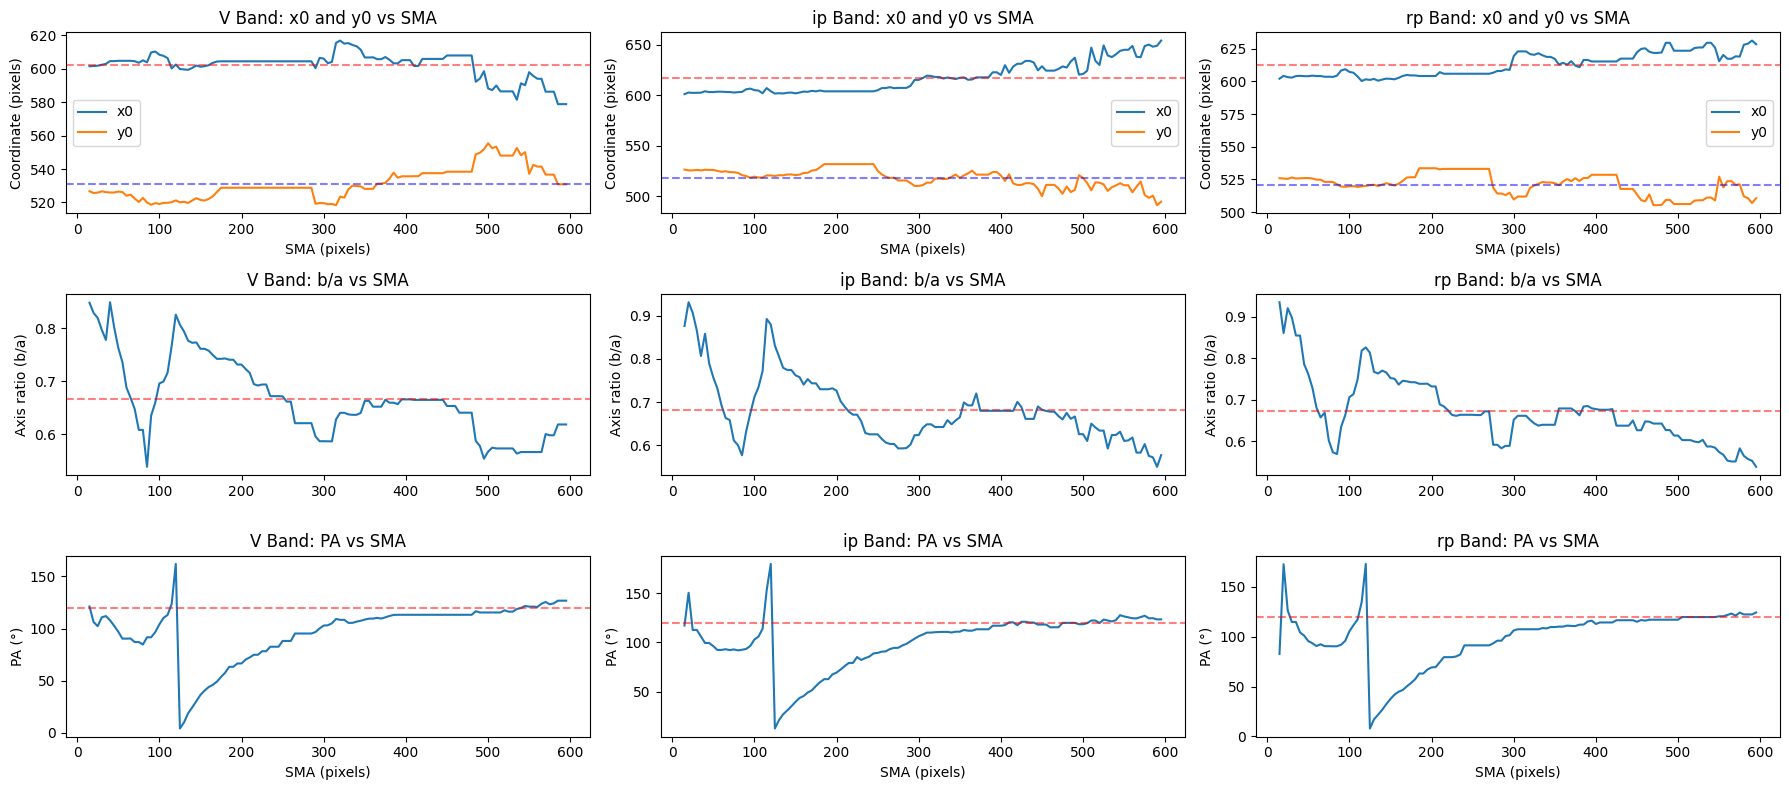

Mean Values of Centroids: 567.0 | Mean Value of Axis Ratio 0.673 | Mean Value of Position Angle = 118.33


In [13]:
#Map centroids, axis ratio, and position angle best fit over semi major axis.
centroids = []
mean_vals = []
fig, axes = plt.subplots(3,3, figsize = (18, 8))
for i, isolist, label in zip((0,1,2),isolists,["V","ip","rp"]):
  x_centres = np.array([iso.x0 for iso in isolist])
  y_centres = np.array([iso.y0 for iso in isolist])
  sma = np.array([iso.sma for iso in isolist])
  PA_deg = np.array([np.rad2deg(iso.pa) for iso in isolist])
  b_a = np.array([1-iso.eps for iso in isolist])
  mean_x = np.mean(x_centres)
  mean_y = np.mean(y_centres)
  centroids.append((mean_x, mean_y))
  print(f"Centroid of {label} Band: ({mean_x:.1f}, {mean_y:.1f})")

  axes[0,i].plot(sma, x_centres, label = "x0")
  axes[0,i].plot(sma, y_centres, label = "y0")
  axes[0,i].axhline(mean_x, color = "red", linestyle = "--", alpha = 0.5)
  axes[0,i].axhline(mean_y, color = "blue", linestyle = "--", alpha = 0.5)
  axes[0,i].set_title(f"{label} Band: x0 and y0 vs SMA")
  axes[0,i].set_xlabel("SMA (pixels)")
  axes[0,i].set_ylabel("Coordinate (pixels)")
  axes[0,i].legend()
  axes[1,i].plot(sma, b_a, label = "b/a")
  axes[1,i].axhline(np.mean(b_a), color = "red", linestyle = "--", alpha = 0.5)
  axes[1,i].set_title(f"{label} Band: b/a vs SMA")
  axes[1,i].set_ylabel("Axis ratio (b/a)")
  axes[2,i].plot(sma, PA_deg, label = "PA")
  axes[2,i].axhline(120, color = "red", linestyle = "--", alpha = 0.5)
  axes[2,i].set_title(f"{label} Band: PA vs SMA")
  axes[2,i].set_ylabel("PA (°)")
  mean_vals.append([np.mean(x_centres), np.mean(y_centres), np.mean(b_a), np.mean(PA_deg)])

for ax in axes[-1, :]:
  ax.set_xlabel("SMA (pixels)")
plt.tight_layout()
plt.show()
print(f"Mean Values of Centroids: {np.mean(centroids):.1f} | Mean Value of Axis Ratio {np.mean(np.array(mean_vals)[:,2]):.3f} | Mean Value of Position Angle = {np.mean([120,120,115]):.2f}")


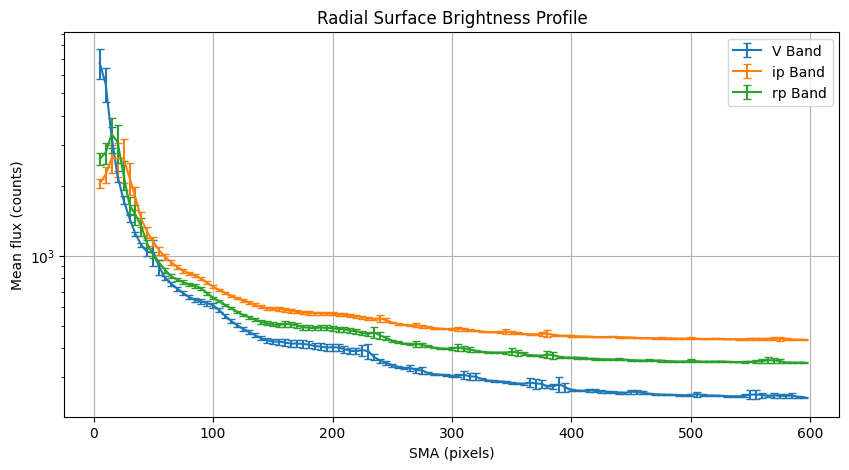

In [14]:
#generate plot of surface brightness for each annulus
b_a = 0.68
PA_deg = 112
PA_rad = np.deg2rad(PA_deg)

radii = np.arange(5,600,5)
bin_width = 5

def elliptical_annulus_mask(shape,center,sma,width,pa,b_a):
  y, x = np.indices(shape)
  x_c, y_c = center
  cos_pa = np.cos(pa)
  sin_pa = np.sin(pa)

  #rotate the coordinates
  dx = x-x_c
  dy = y-y_c
  x_rot = dx*cos_pa + dy*sin_pa
  y_rot = -dx*sin_pa + dy*cos_pa

  r_ell = np.sqrt((x_rot / sma)**2 + (y_rot/(sma * b_a))**2)
  r_ell_inner = np.sqrt((x_rot / (sma - width))**2 + (y_rot/((sma-width) * b_a))**2)

  return (r_ell < 1) & (r_ell_inner > 1)

def radial_profile(data, center, radii, width, pa, b_a):
  mean_fluxes = []
  flux_errors = []

  for sma in radii:
    mask = elliptical_annulus_mask(data.shape, center, sma, width, pa, b_a)
    values = data[mask]

    mean_flux = np.nanmean(values)
    std = np.nanstd(values)
    n_pixels = np.count_nonzero(~np.isnan(values))
    flux_error = np.sqrt((std**2) / np.sqrt(n_pixels))

    mean_fluxes.append(mean_flux)
    flux_errors.append(flux_error)

  mean_fluxes = np.array(mean_fluxes)
  flux_errors = np.array(flux_errors)
  return mean_fluxes, flux_errors

profile_V, error_V = radial_profile(masked_fits[0], centroids[0], radii, bin_width, PA_rad, b_a)
profile_ip, error_ip = radial_profile(masked_fits[1], centroids[1], radii, bin_width, PA_rad, b_a)
profile_rp, error_rp = radial_profile(masked_fits[2], centroids[2], radii, bin_width, PA_rad, b_a)
profiles = [profile_V, profile_ip, profile_rp]
errors = [error_V, error_ip, error_rp]

figure = plt.figure(figsize=(10, 5))

for profile, error, label in zip(profiles, errors, ["V", "ip", "rp"]):
    plt.errorbar(radii, profile, yerr=error, fmt='-', capsize=3, label = f"{label} Band")

plt.xlabel("SMA (pixels)")
plt.ylabel("Mean flux (counts)")
plt.yscale("log")
plt.title("Radial Surface Brightness Profile")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
 print(error_V)

[980.48052598 919.58851369 324.30339758 123.76675829  70.9510229
  46.71391287  28.50784245  22.50071783  40.60399828 132.70993053
  63.64694538  16.8741041   13.56644497  14.40413417  15.44397216
  13.9945558   12.88266046  14.22549415  14.69376497  15.77843105
  13.0417937    9.7009399    9.18295756   9.55943151   9.79011584
   9.75897152   9.53968261   9.55703568   9.74153683  10.926772
  12.74551104  13.30004481  13.1679446   13.48461937  16.18899637
  15.11389443  12.71515401  13.41521819  13.21668906  13.67108324
  13.32601689  13.16421452  12.50419198  12.30474307  21.34011898
  29.49768525  10.69309744   6.9048951    6.32342843   5.19947252
   4.39981694   4.33051263  10.60784006   8.22298376  12.50587595
   3.298718     2.17667844   2.24425878   2.25638108   2.20685731
   4.55153112  13.27776528  10.56092444  10.91425742   3.86920332
   1.69435048   1.82620319   2.20672301   1.94048397   1.76958431
   2.05521021   3.07543514  11.94559233  13.84732859  11.21111516
   3.9209533 

In [16]:
#convert flux data to relative magnitude data
def flux2mag(flux_array):
  return -2.5 * np.log10(flux_array)

mag_V = flux2mag(profile_V)
mag_ip = flux2mag(profile_ip)
mag_rp = flux2mag(profile_rp)

mag_errors_V = 2.5/np.log(10) * error_V/profile_V
mag_errors_ip = 2.5/np.log(10) * error_ip/profile_ip
mag_errors_rp = 2.5/np.log(10) * error_rp/profile_rp

In [17]:
#smooth magnitude data to reduce high-frequency noise in data
smoothed_mag_V = gaussian_filter1d(mag_V, sigma=1)
smoothed_mag_ip = gaussian_filter1d(mag_ip, sigma=1)
smoothed_mag_rp = gaussian_filter1d(mag_rp, sigma=1)

In [18]:
colour_V_ip = smoothed_mag_V - smoothed_mag_ip
colour_V_rp = smoothed_mag_V - smoothed_mag_rp
colour_rp_ip = smoothed_mag_rp - smoothed_mag_ip

colour_error_V_ip = np.sqrt(mag_errors_V**2 + mag_errors_ip**2)
colour_error_V_rp = np.sqrt(mag_errors_V**2 + mag_errors_rp**2)
colour_error_rp_ip = np.sqrt(mag_errors_rp**2 + mag_errors_ip**2)

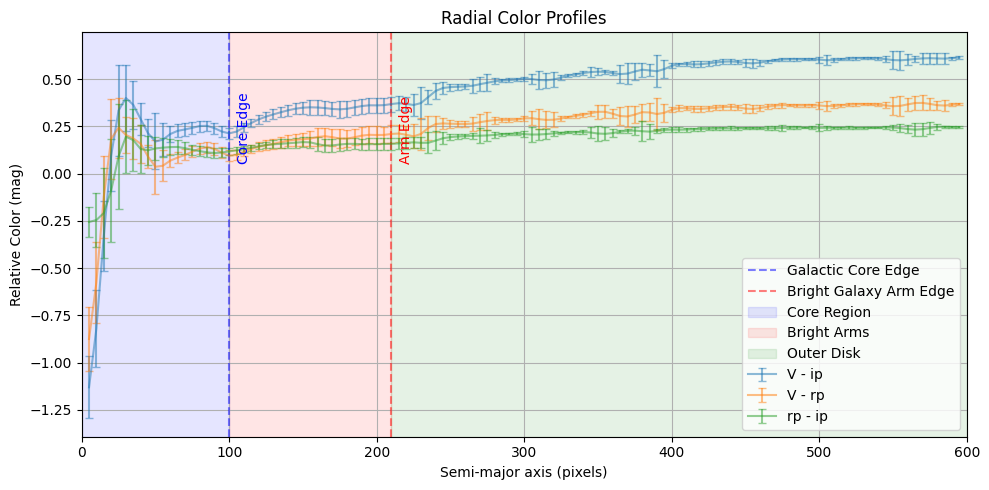

In [22]:
plt.figure(figsize=(10, 5))
plt.errorbar(radii, colour_V_ip, yerr=colour_error_V_ip, fmt='-', capsize=3, label = "V - ip", alpha = 0.5)
plt.errorbar(radii, colour_V_rp, yerr=colour_error_V_rp, fmt='-', capsize=3, label = "V - rp", alpha = 0.5)
plt.errorbar(radii, colour_rp_ip, yerr=colour_error_rp_ip, fmt='-', capsize=3, label = "rp - ip", alpha = 0.5)
plt.axvline(x=100,color='blue',linestyle='--',alpha=0.5,label = "Galactic Core Edge")
plt.axvline(x=210,color='red',linestyle='--',alpha=0.5,label = "Bright Galaxy Arm Edge")
plt.text(100 + 5, 0.05, 'Core Edge', rotation=90, color='blue', va='bottom')
plt.text(210 + 5, 0.05, 'Arm Edge', rotation=90, color='red', va='bottom')
plt.axvspan(0, 100, color='blue', alpha=0.1, label='Core Region')
plt.axvspan(100, 210, color='red', alpha=0.1, label='Bright Arms')
plt.axvspan(210, 600, color='green', alpha=0.1, label='Outer Disk')
plt.xlim(0, 600)
plt.xlabel("Semi-major axis (pixels)")
plt.ylabel("Relative Color (mag)")
plt.title("Radial Color Profiles")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
log_radii = np.log10(radii)
from scipy.stats import linregress
log_rmin = 2.0
log_rmax = 2.55
def fit_colour_grad(log_r, colour, colour_err, log_rmin = log_rmin, log_rmax = log_rmax):
  mask = (log_r >= log_rmin) & (log_r <= log_rmax)
  x = log_r[mask]
  y = colour[mask]
  weights = 1 / (colour_err[mask] ** 2)
  """print(f"\n--- Debug: {len(x)} points in mask ---")
  print("x (log_radii):", x)
  print("y (colour):", y)
  print("Any NaNs in x?", np.isnan(x).any())
  print("Any NaNs in y?", np.isnan(y).any())
  print("Min/max of x:", np.min(x), np.max(x))
  print("Min/max of y:", np.min(y), np.max(y))"""


  A = np.vstack([x, np.ones(len(x))]).T
  W = np.diag(weights)

  cov = np.linalg.inv(A.T @ W @ A)
  slope, intercept = np.linalg.lstsq(W@A, W@y, rcond=None)[0]
  std_err = np.sqrt(np.diag(cov))[0]

  y_fit = slope * x + intercept
  ss_res = np.sum(weights * (y-y_fit)**2)
  ss_tot = np.sum(weights * (y-np.average(y, weights = weights))**2)
  if ss_res > ss_tot:
    print("Warning: residuals exceed total variance. Noisy data likely.")
  r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
  r_value = np.sqrt(r_squared) if r_squared >= 0 else 0

  return slope, intercept, r_value, std_err, mask

v_ip_linreg = fit_colour_grad(log_radii, colour_V_ip, colour_error_V_ip)
v_rp_linreg = fit_colour_grad(log_radii, colour_V_rp, colour_error_V_rp)
rp_ip_linreg = fit_colour_grad(log_radii, colour_rp_ip, colour_error_rp_ip)

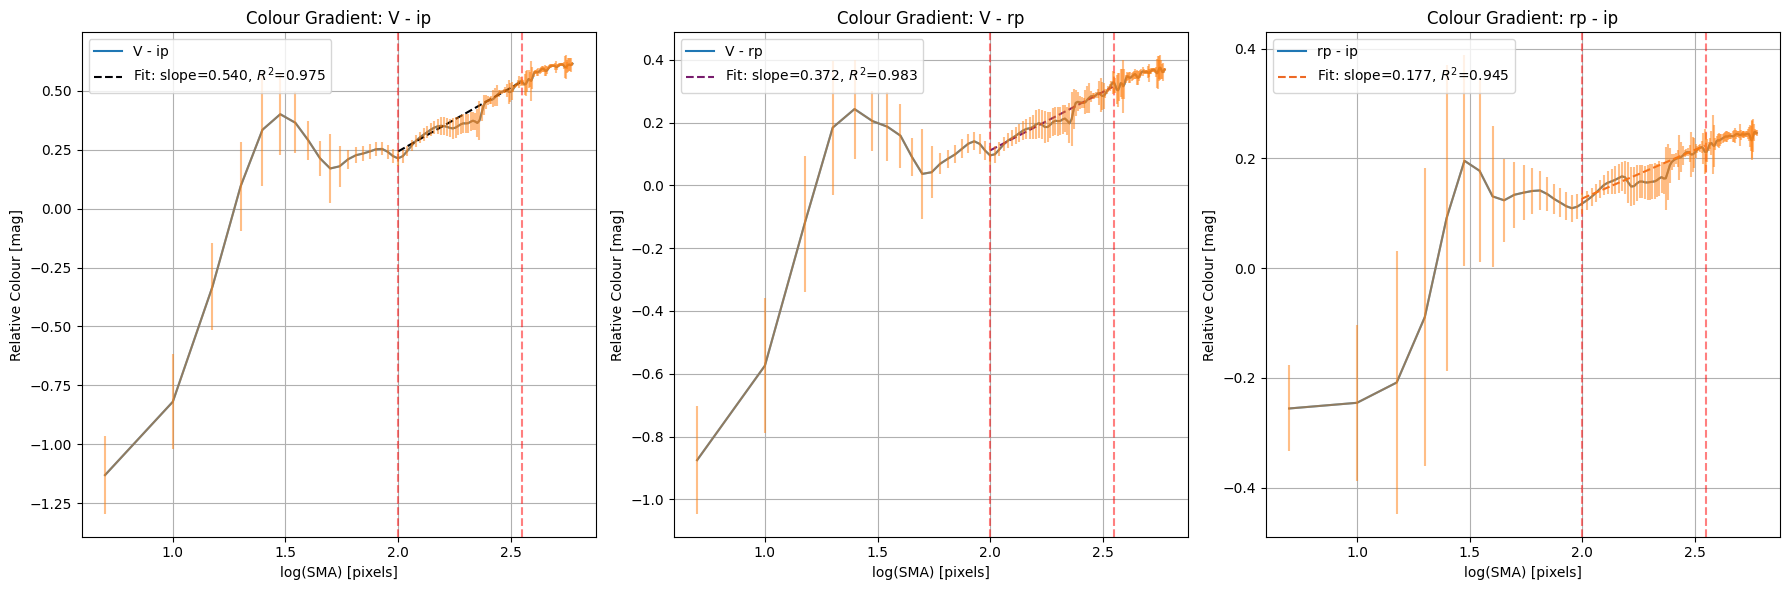

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Adjust height to match layout
linregs = [v_ip_linreg, v_rp_linreg, rp_ip_linreg]
colour_profiles = [colour_V_ip, colour_V_rp, colour_rp_ip]
colour_errors = [colour_error_V_ip, colour_error_V_rp, colour_error_rp_ip]
labels = ["V - ip", "V - rp", "rp - ip"]

# Loop through each subplot
for i, ((slope, intercept, r_value, std_err, fit_mask), colour_profile, colour_error, label) in enumerate(zip(linregs, colour_profiles, colour_errors, labels)):
    fit_line = slope * log_radii + intercept

    ax[i].plot(log_radii, colour_profile, label=label)
    ax[i].plot(log_radii[fit_mask], fit_line[fit_mask], "--", color=cm.inferno(i / 3),
               label=f'Fit: slope={slope:.3f}, $R^2$={r_value**2:.3f}')

    ax[i].axvline(log_rmin, color='red', linestyle='--', alpha=0.5)
    ax[i].axvline(log_rmax, color='red', linestyle='--', alpha=0.5)

    ax[i].errorbar(log_radii, colour_profile, yerr=colour_error, fmt='-', alpha = 0.5)

    ax[i].set_xlabel("log(SMA) [pixels]")
    ax[i].set_ylabel("Relative Colour [mag]")
    ax[i].set_title(f"Colour Gradient: {label}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()
